In [9]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import spacy 
from tqdm import tqdm_notebook
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
import pyLDAvis
import pyLDAvis.gensim
import os
import gensim
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [6]:
PATH_DF = '/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Lab Sessions/english_cleaned_lyrics.csv'
PATH_CORRECTION = '/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Lab Sessions/indx2newdate.p'

In [7]:
def load_dataset(data_path, path_correction):
    df = pd.read_csv(data_path)
    indx2newdata = pickle.load(open(PATH_CORRECTION, 'rb'))
    df['year'] = df['index'].apply(lambda x: int(indx2newdata[x][0][:4])
                                   if indx2newdata[x][0] != '' else 0)
    return df[df.year > 1960] [['song', 'year', 'artist', 'genre', 'lyrics']]
dataset = load_dataset(PATH_DF, PATH_CORRECTION)

1. Count how many songs of each genre are in the data set, and pick a genre that 1) you think is interesting to explore and 2) has over 5.000 songs. Make a subset of the data set only containing songs of that genre; this is the data set you work with for the rest of these exercises. 

In [8]:
dataset.value_counts('genre')

genre
Rock          77556
Pop           23295
Metal         15671
Hip-Hop       14878
Country       10545
Electronic     5194
Jazz           5068
Indie          2489
Other          2449
R&B            2338
Folk           1373
dtype: int64

2. Inspect the number of songs for each year, either using a data frame or using a visualization. Do you think you have enough songs for each year (at least more than fifty)? If not, filter out the years that do not contain enough songs.

I'm choosing the Rock genre since there are a lot of records. 

<AxesSubplot:>

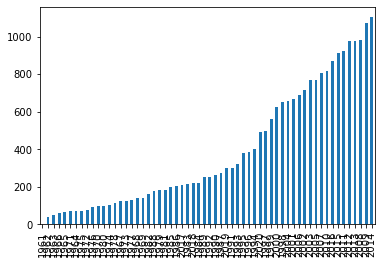

In [10]:
pop = dataset.loc[dataset['genre'] == 'Pop']
pop['year'].value_counts().sort_values().plot(kind='bar')

3. Process the texts of your genre (and only your genre!) using Spacy. Extract the lemmatized tokens for each song, and remove stopwords.

In [11]:
lyrics = pop.lyrics
nlp = spacy.load('en_core_web_sm')
processed_texts = [text for text in tqdm_notebook(nlp.pipe(lyrics,
                                            disable=["ner",
                                                    "parser"]))]
pop['processed_texts'] = processed_texts

In [12]:
processed_texts = pop.processed_texts
lemmatized_texts_nouns = [[token.lemma_ for token in text 
                           if not token.is_punct
                          and not token.is_stop] 
                          for text in processed_texts]
pop['lemmatized'] = lemmatized_texts_nouns

4. Create a dictionary and filter out the words that occur less than three times, and all words that occur in over 85% of the documents.


In [13]:
MIN_DF = 3
MAX_DF = 0.85
tokenized_texts = pop['lemmatized']
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=MIN_DF,
                          no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

5. Train a topic model with 50 topics and inspect the output, both using the ten most relevant words for each topics, and using pyLDAvis. Now also run a topic model with 20 topics, and one with 100 topics. Be sure to save the models using lda.save(’folder/to/save’) What number of topics does result in the “best” topics? [Note: how you operationalize
“best” is up to you]

In [14]:
PATH_TO_MALLET = '/Users/jaspervogelzang/mallet-2.0.8/bin/mallet'

N_TOPICS = 20
N_ITERATIONS = 1000

lda = LdaMallet(PATH_TO_MALLET,
               corpus=corpus,
               id2word=dictionary,
               num_topics=N_TOPICS,
               iterations=N_ITERATIONS)

In [176]:
lda.save('/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Lab Sessions/lda20')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
for topic in range(N_TOPICS):
    words = lda.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))   

Topic 0: wanna hey walk na talk matter secret honey count Wanna
Topic 1: life find leave live die reason learn promise alive breathe
Topic 2: free rain set follow wind sea grow line water carry
Topic 3: la high kiss da fly blue sky lip La taste
Topic 4: turn lose hard head work fight touch easy lover catch
Topic 5: night dream light sun fire star shine sleep burn morning
Topic 6: heart fall break cry lie tear hurt give start pain
Topic 7: run Christmas year home town big lot black trouble white
Topic 8: hear word song sing call listen sound summer voice write
Topic 9: day bring remember forget people beautiful smile hope meet world
Topic 10: boy play ah uh game young pretty fool hate cool
Topic 11: time hold wait long forever end miss chance arm late
Topic 12: baby good thing care friend bad Baby babe trust understand
Topic 13: yeah tonight ooh crazy alright happy Ooh fine ha drive
Topic 14: stop dance home body beat ready shake rock music party
Topic 15: love true Love sweet touch giv

In [16]:
pyLDAvis.enable_notebook()
lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda)
pyLDAvis.gensim.prepare(lda_conv, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.239805 -0.037846       1        1  6.605393
14     0.143639  0.109882       2        1  5.206657
17    -0.114787 -0.187703       3        1  5.077618
7      0.212955  0.052111       4        1  5.069398
6     -0.141228 -0.078375       5        1  5.068480
11    -0.129393  0.017586       6        1  5.042288
10     0.147819 -0.021809       7        1  5.038212
12    -0.072414 -0.113403       8        1  5.026077
15    -0.116424 -0.096489       9        1  4.999728
4      0.013827 -0.032695      10        1  4.972622
5     -0.055800 -0.039308      11        1  4.951061
1     -0.211132  0.051616      12        1  4.934940
13     0.061085 -0.194832      13        1  4.912351
19    -0.058130  0.204444      14        1  4.870396
2     -0.012374  0.072966      15        1  4.860144
16    -0.003841  0.144723      16        1  4.801830
9     -0.100558  0.248341      17        1  4.747129
0      0.056062 -0.108471      18        1  4.703444
8      0.073731  0.071041      19        1  4.680715
3      0.067157 -0.061780      20        1  4.431516, topic_info=       Term          Freq         Total Category  logprob  loglift
45     love  75733.000000  75733.000000  Default  30.0000  30.0000
5      baby  30915.000000  30915.000000  Default  29.0000  29.0000
26     feel  29546.000000  29546.000000  Default  28.0000  28.0000
222    time  29270.000000  29270.000000  Default  27.0000  27.0000
319    yeah  25822.000000  25822.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
2081    eat    623.088734    866.904493  Topic20  -5.0714   2.7862
1090  sweet   1486.718701   3994.016339  Topic20  -4.2018   2.1282
1039    low    752.053612   1787.280254  Topic20  -4.8833   2.2508
1687   lock    533.248033   1019.981683  Topic20  -5.2271   2.4679
677    ride    554.983687   3211.896984  Topic20  -5.1872   1.3608

[1560 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
393       1  0.999838  -PRON-
7607      1  1.005362       0
1431      1  0.987641       1
1431      3  0.012282       1
1557      1  0.998901       2
...     ...       ...     ...
176      20  0.025651      yo
6609     19  0.961917     yoo
699       7  0.914664   young
699      17  0.085265   young
4147      8  1.015542  your'e

[2296 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 15, 18, 8, 7, 12, 11, 13, 16, 5, 6, 2, 14, 20, 3, 17, 10, 1, 9, 4])

6. Make a change in the preprocessing stage and run the topic model again. This could be: not removing stop words, only selecting nouns
2/3
Tutorial 2.2 By Joris Veerbeek
(or only nouns, adjectives and verbs – something I do quite often when topic modeling), not using lemmas but tokens, etc. Inspect the output. Name one benefit and one downside of the change you selected on the preprocessing stage for finding useful topics.

In [19]:
processed_texts = pop.processed_texts
lemmatized_texts_nouns = [[token.lemma_ for token in text
                           if token.pos_ == 'NOUN'or 
                           token.pos_ == 'ADJ' or
                           token.pos_ == 'VERB'
                           if not token.is_punct
                          and not token.is_stop] 
                          for text in processed_texts]
pop['lemmatized2'] = lemmatized_texts_nouns

MIN_DF = 3
MAX_DF = 0.85
tokenized_texts = pop['lemmatized2']
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=MIN_DF,
                          no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

os.environ['MALLET_HOME']='C://Users//jaspervogelzang//mallet-2.0.8'

PATH_TO_MALLET = '/Users/jaspervogelzang/mallet-2.0.8/bin/mallet'

N_TOPICS = 20
N_ITERATIONS = 1000

lda3 = LdaMallet(PATH_TO_MALLET,
               corpus=corpus,
               id2word=dictionary,
               num_topics=N_TOPICS,
               iterations=N_ITERATIONS)

pyLDAvis.enable_notebook()
lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda3)
pyLDAvis.gensim.prepare(lda_conv, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.224427  0.042247       1        1  5.958329
6     -0.240947  0.037679       2        1  5.431327
1      0.057207 -0.139833       3        1  5.280487
14     0.133768  0.158255       4        1  5.238931
0      0.065499  0.181881       5        1  5.081378
8     -0.194705 -0.033018       6        1  5.080021
19    -0.039570  0.094529       7        1  4.973966
3     -0.011646  0.078063       8        1  4.954342
15     0.006427 -0.013968       9        1  4.949142
18     0.072852 -0.237156      10        1  4.938047
2      0.065167  0.015091      11        1  4.893275
7      0.131307 -0.129261      12        1  4.867497
5      0.190874 -0.020130      13        1  4.866692
10     0.082249  0.142018      14        1  4.826768
13    -0.028182  0.031391      15        1  4.809037
17     0.046016  0.001630      16        1  4.795519
16    -0.007062  0.133497      17        1  4.784808
4     -0.126663 -0.215115      18        1  4.782712
12     0.099689 -0.102672      19        1  4.759109
9     -0.077855 -0.025128      20        1  4.728612, topic_info=         Term          Freq         Total Category  logprob  loglift
38       love  70725.000000  70725.000000  Default  30.0000  30.0000
21       feel  29453.000000  29453.000000  Default  29.0000  29.0000
2        baby  29458.000000  29458.000000  Default  28.0000  28.0000
186      time  29046.000000  29046.000000  Default  27.0000  27.0000
26      heart  21619.000000  21619.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1146  explain    392.655732    694.164957  Topic20  -5.3725   2.4818
1362  thunder    289.256389    394.937245  Topic20  -5.6781   2.7401
380      deep    431.921305   1511.143070  Topic20  -5.2772   1.7992
99       make    547.100320   5631.311243  Topic20  -5.0408   0.7201
138      move    363.860979   2139.184922  Topic20  -5.4486   1.2801

[1519 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
7964      4  0.997435        1st
5397     17  1.009566        2nd
5021      1  1.002377        8th
8059      3  0.973035       Fish
1645     12  1.000161         Na
...     ...       ...        ...
1365     18  1.000275     yellow
1241     17  0.999951  yesterday
4770      2  1.002100         yo
534       7  1.000113      young
2764     15  1.001188       zoom

[2144 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 7, 2, 15, 1, 9, 20, 4, 16, 19, 3, 8, 6, 11, 14, 18, 17, 5, 13, 10])


8. Look at the topics that have declined, and the topics that have increased. Think of a label for these topics. Visualize the results and write a (very) short report on the results of this analysis.

In [20]:
for topic in range(N_TOPICS):
    words = lda3.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: girl good boy bad real meet fine kind guy worth
Topic 1: day night dream light sky sun star fly shine sleep
Topic 2: find run place stand face remember open door hide road
Topic 3: baby hold hand crazy feeling chance arm promise happen drive
Topic 4: bring year cold child grow wind warm white tree snow
Topic 5: time hear end friend start fight long lover begin spend
Topic 6: dance body beat stop shake rock ride music party step
Topic 7: heart break stay word song forget sing learn story start
Topic 8: wanna tonight watch home happy alright town lady fun cool
Topic 9: feel fall rain call catch ground breathe sound air wall
Topic 10: cry walk lie care tear hurt die pain reason woman
Topic 11: big money hot pay car lot bout buy shit street
Topic 12: wait give free hope people beautiful save blue set moment
Topic 13: eye kiss touch fire high close burn ready reach lip
Topic 14: love true miss sweet share emotion surrender romance tender dot
Topic 15: thing mind head make work line

In [21]:
transformed_docs = lda3.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(N_TOPICS)])
print(topic_distributions.head())
print(topic_distributions.mean().sort_values(ascending=False))

    topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0  0.030612  0.017007  0.037415  0.030612  0.017007  0.037415  0.030612   
1  0.026882  0.026882  0.048387  0.048387  0.091398  0.080645  0.059140   
2  0.093496  0.060976  0.069106  0.052846  0.028455  0.060976  0.028455   
3  0.065217  0.021739  0.021739  0.082609  0.030435  0.021739  0.039130   
4  0.044118  0.014706  0.055882  0.020588  0.014706  0.097059  0.085294   

    topic_7   topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  \
0  0.051020  0.017007  0.037415  0.071429  0.275510  0.051020  0.030612   
1  0.059140  0.048387  0.026882  0.112903  0.026882  0.026882  0.037634   
2  0.036585  0.020325  0.028455  0.020325  0.020325  0.117886  0.085366   
3  0.039130  0.039130  0.030435  0.056522  0.100000  0.039130  0.021739   
4  0.061765  0.026471  0.073529  0.108824  0.032353  0.032353  0.185294   

   topic_14  topic_15  topic_16  topic_17  topic_18  topic_19  
0  0.037415  0.044218  0.044218  0

In [28]:
data

,year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,1961,0.041692,0.029034,0.062790,0.037473,0.075078,0.049498,0.037884,0.060250,0.029034,...,0.043823,0.029034,0.046812,0.082132,0.099656,0.029034,0.033254,0.036429,0.029034,0.034934
1,1962,0.050691,0.054902,0.043959,0.042920,0.070444,0.049316,0.041612,0.052950,0.041902,...,0.038936,0.068807,0.045583,0.057428,0.062829,0.046222,0.048132,0.040014,0.055684,0.045205
2,1963,0.044674,0.057592,0.049500,0.041825,0.103886,0.043910,0.039055,0.055232,0.045560,...,0.054129,0.050315,0.047260,0.040373,0.053751,0.042591,0.044105,0.043143,0.058098,0.039344
3,1964,0.049414,0.054568,0.045920,0.060959,0.054116,0.048162,0.038240,0.052011,0.041534,...,0.064373,0.048096,0.046749,0.048156,0.069646,0.049875,0.047108,0.048419,0.046862,0.045454
4,1965,0.051138,0.057234,0.042977,0.054588,0.082716,0.049317,0.036769,0.046563,0.045748,...,0.056277,0.039603,0.047061,0.048866,0.061827,0.044423,0.047311,0.046784,0.054510,0.046978
5,1966,0.043384,0.061217,0.046336,0.053399,0.063229,0.055431,0.038406,0.061166,0.046123,...,0.051335,0.039620,0.047872,0.048176,0.059258,0.047243,0.051796,0.051906,0.043090,0.048865
6,1967,0.050194,0.064754,0.047266,0.048078,0.073362,0.045008,0.038976,0.052861,0.042414,...,0.047927,0.037931,0.051380,0.047416,0.065707,0.043089,0.049991,0.043740,0.055738,0.050712
7,1968,0.044004,0.056827,0.047274,0.048073,0.059293,0.046694,0.043987,0.049193,0.039287,...,0.051533,0.047122,0.055217,0.046667,0.069935,0.045602,0.056263,0.046741,0.054629,0.048041
8,1969,0.053405,0.071410,0.049086,0.044644,0.060797,0.054907,0.039452,0.052797,0.039129,...,0.051279,0.049715,0.045866,0.043866,0.059607,0.048051,0.048129,0.042496,0.051766,0.054155
9,1970,0.046569,0.064410,0.052963,0.048682,0.054357,0.048740,0.036753,0.046839,0.047705,...,0.056005,0.037179,0.050707,0.048226,0.055970,0.045774,0.057449,0.051630,0.053019,0.052674


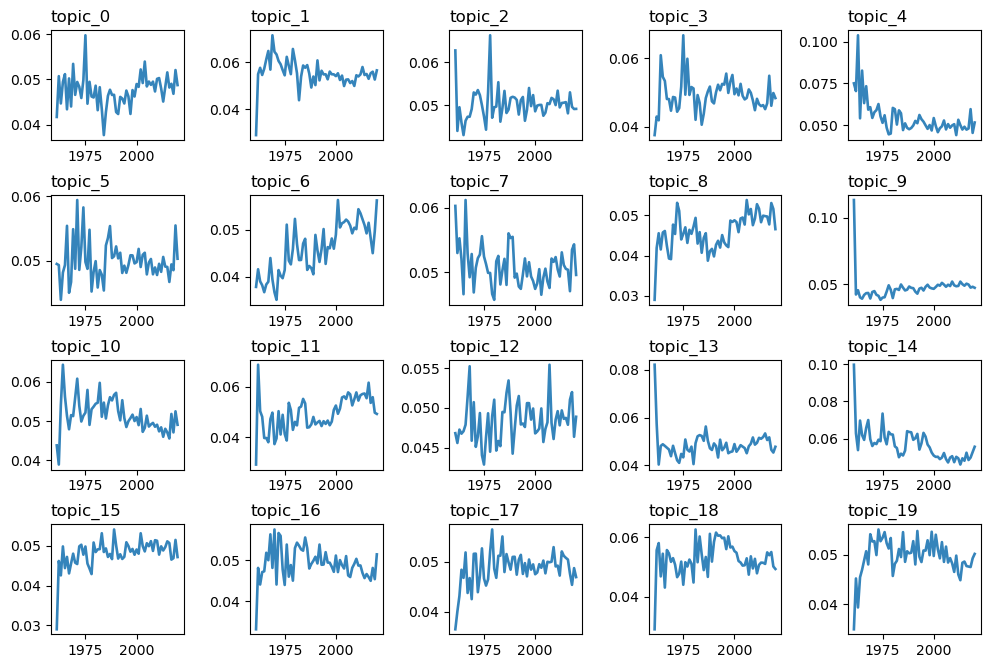

In [27]:
joined_topic_dist = pop.reset_index().join(topic_distributions)
grouped_by_year = joined_topic_dist.groupby('year').mean()
data = grouped_by_year
del data['index']
data.reset_index(inplace=True)
num=0
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
for column in data.drop('year', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(4,5, num)
    plt.subplots_adjust(wspace=.5, hspace=.5)
 
    # Plot the lineplot
    plt.plot(data['year'], data[column], marker='', linewidth=1.9, alpha=0.9, label=column)
    plt.title(column, loc='left', fontsize=12, fontweight=0)



In [323]:
grouped_by_year = grouped_by_year.rename(columns={'topic_0': 'Explicit language', 'topic_1': 'Sadness', 'topic_5': 'Day and Light', 'topic_8': 'Romance', 'topic_15': 'Party'})
df = grouped_by_year

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


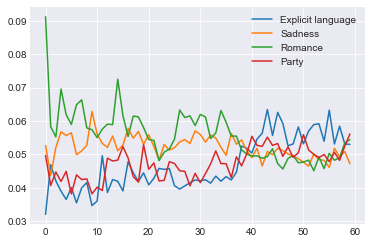

In [324]:
# multiple line plot
plt.plot('Explicit language', data=df)
plt.plot('Sadness', data=df)
plt.plot('Romance', data=df)
plt.plot('Party', data=df)
plt.legend()


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


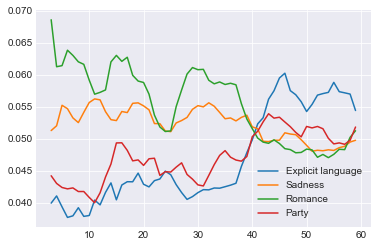

In [325]:
rolling_means = df.rolling(4).mean().dropna()
df = rolling_means

# multiple line plot
plt.plot('Explicit language', data=df)
plt.plot('Sadness', data=df)
plt.plot('Romance', data=df)
plt.plot('Party', data=df)
plt.legend()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='year'>

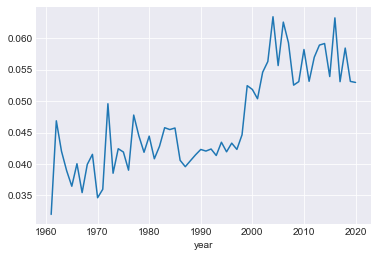

In [326]:
joined_topic_dist = pop.reset_index().join(topic_distributions)
grouped_by_year = joined_topic_dist.groupby('year').mean()

def get_trends(X,Y, order=1):
    result = np.polyfit(X, list(Y), order)
    slope = result[-2]
    return float(slope)

trends = []
for i in range(N_TOPICS):
    index = grouped_by_year.index.values
    topic_prop = grouped_by_year['topic_{}'.format(i)].values
    trend = get_trends(index, topic_prop)
    trends.append([i, trend])

trends_df = pd.DataFrame(trends, columns=['topic', 'trend'])
trends_df.sort_values('trend', ascending=True)
grouped_by_year['topic_0'].plot()

To get a smoothed trend, we can use a rolling mean instead:

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='year'>

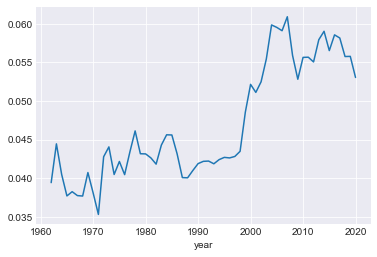

In [327]:
rolling_means = grouped_by_year.rolling(2).mean().dropna() 

def get_trends(X,Y, order=1):
    result = np.polyfit(X, list(Y), order)
    slope = result[-2]
    return float(slope)

trends = []
for i in range(N_TOPICS):
    index = rolling_means.index.values
    topic_prop = rolling_means['topic_{}'.format(i)].values
    trend = get_trends(index, topic_prop)
    trends.append([i, trend])

trends_df = pd.DataFrame(trends, columns=['topic', 'trend'])
trends_df.sort_values('trend', ascending=True)
rolling_means['topic_0'].plot()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
No handles with labels found to put in legend.


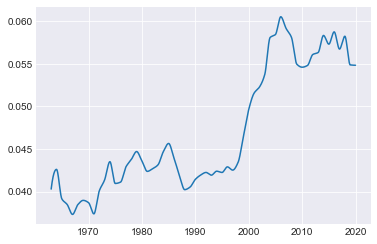

In [328]:
from scipy.interpolate import pchip 

def smooth(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    X_smooth = np.linspace(X.min(),X.max(), 5000)
    pch = pchip(X, Y)
    Y_smooth = pch(X_smooth)
    return X_smooth, Y_smooth

TOPIC2PLOT = 0 # plot topic 0
rolling_means = grouped_by_year.rolling(3).mean().dropna()
X = rolling_means.index
Y = rolling_means['topic_{}'.format(TOPIC2PLOT)]
x_smooth,y_smooth = smooth(X,Y)

%matplotlib inline 

topic_labels = 'Topic {}:'.format(TOPIC2PLOT) + ' '.join([word[0] for word in lda.show_topic(TOPIC2PLOT, 10)])
plt.plot(x_smooth,y_smooth)
plt.legend()